In [2]:
from Utils import SpEC_class_2 as spu
from Utils.SpEC_class_2 import *
import pandas as pd
from pathlib import Path
import cmcrameri.cm as cmc  #scientific color maps - perceptually uniform
from scipy.optimize import lsq_linear


In [3]:
path=Path.cwd().joinpath('Data')


<Axes: >

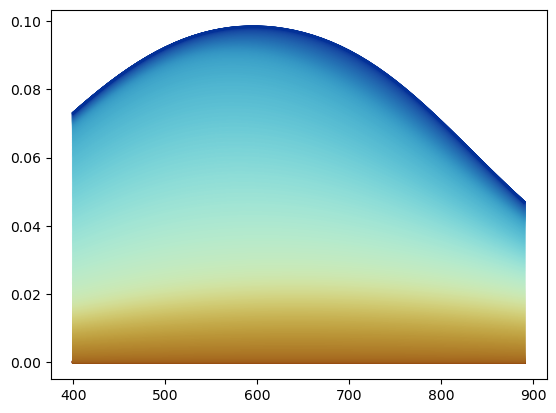

In [4]:
spec=pd.read_parquet(path.joinpath('SpEC.parquet'))
spec.plot(colormap=cmc.roma,legend=False)

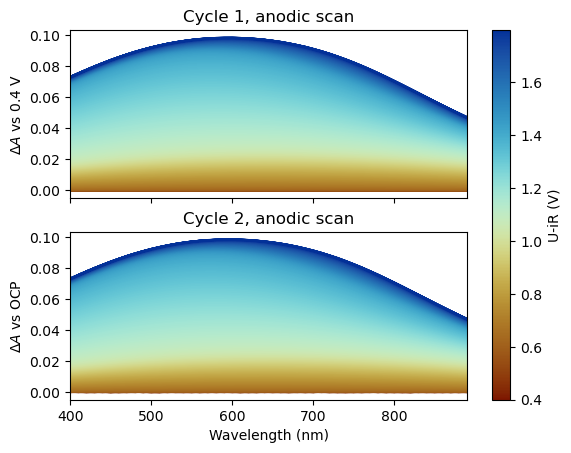

In [5]:
# simulate two cycles that are the result of reversible changes by adding random noise to the data on the order of 5E-5
spec_cyle1=spec+np.random.normal(0,3E-5,spec.shape)
spec_cycle2=spec+np.random.normal(0,3E-5,spec.shape)

fig, ax = plt.subplots(nrows=2, sharex=True)
spec_cyle1.plot(colormap=cmc.roma,legend=False, ax=ax[0],title='Cycle 1, anodic scan')
spec_cycle2.plot(colormap=cmc.roma,legend=False, ax=ax[1], title='Cycle 2, anodic scan')

# x label for ax1 is Wavelengt (nm)
ax[1].set_xlabel('Wavelength (nm)')

# y label for both is r$\DeltaA$ vs OCP
ax[0].set_ylabel(r'$\Delta A$ vs 0.4 V')
ax[1].set_ylabel(r'$\Delta A$ vs OCP')

ax[0].set_xlim(400,890)
ax[1].set_xlim(400,890)

#create scalar mappable for the color bar
mappable = plt.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=spec.columns.values.min(), vmax=spec.columns.values.max()))
# create a color bar for fig[1]
fig.colorbar(ax=ax, mappable=mappable,
              label=r'U-iR (V)')
# fig.colorbar(ax=ax[0], mappable=mappable,
#               label=r'$\Delta$A vs 0.4 V')



(400.0, 890.0)

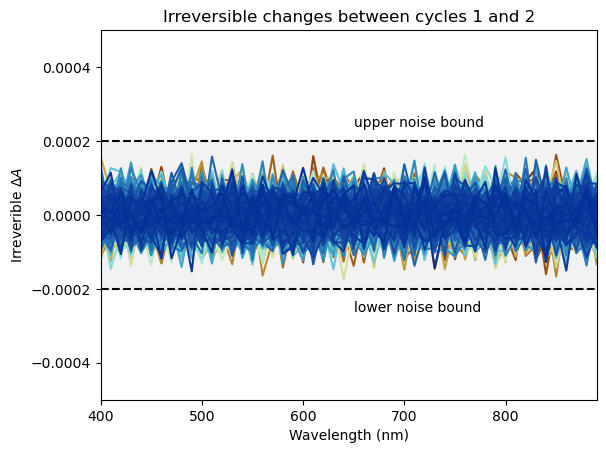

In [6]:

fig0, ax0 = plt.subplots()

reversibility_residuals=spec_cyle1-spec_cycle2
reversibility_residuals.plot(colormap=cmc.roma,legend=False, ylim=(-5E-4,5E-4), ax=ax0)

# add a dashed line at y= 2E-4 above it label 'upper noise bound'
ax0.axhline(2E-4, color='black', linestyle='--')
ax0.text(650, 2.5E-4, 'upper noise bound', rotation=0, verticalalignment='center')
ax0.axhline(-2E-4, color='black', linestyle='--')
ax0.text(650, -2.5E-4, 'lower noise bound', rotation=0, verticalalignment='center')

# fill the area between the two dashed lines with a light grey color
ax0.fill_between(reversibility_residuals.index, 2E-4, -2E-4, color='grey', alpha=0.1)

# xlim between 500 and 900

ax0.set_xlim(500,900)

# x label for ax1 is Wavelength (nm)

ax0.set_xlabel('Wavelength (nm)')

# y label for both is r$\DeltaA$
ax0.set_ylabel(r'Irreverible $\Delta A$') 
# title is 'Irreversible changes between cycles 1 and 2'
ax0.set_title('Irreversible changes between cycles 1 and 2')

# for both ax xlim 400 to 890
ax0.set_xlim(400,890)


Text(0, 0.5, '$\\Delta$A (Norm.)')

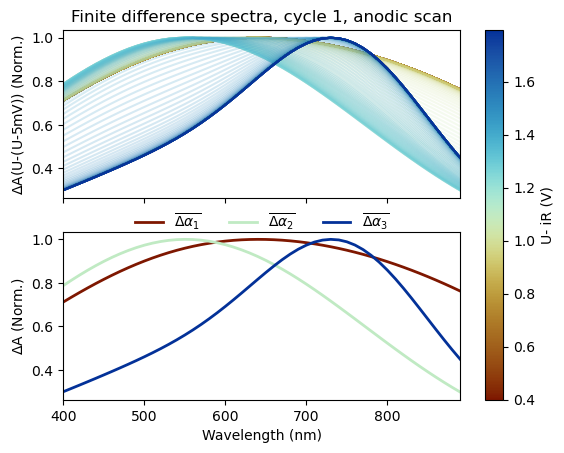

In [7]:
"""SpEC is an analysis class processing and analysing raw spectal data but as this data is already 
proessed we can use its analysis methods to analyse the data"""
""

# the first thing we can do is take a finite difference approximation of the potential deterivitive
# as this synthetic data is purposley chosen to be noiseless, the derivative will be exact however,
# in real data we often have too much noise to take very small steps so we would need to take a larger step
# here we will will use 5mV steps but the function below can be used to take any step size
# 

finite_diff_norm=calculate_differential_spectra(DOD_dataframe=spec, voltage_step=0.005, Normalise=True, smooth_strength=0) 

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
# reverse the order of the collumns to make the plot more readable
finite_diff_norm[finite_diff_norm.columns].plot(colormap=cmc.roma,legend=False, alpha=0.2, ax=ax[0])

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmc.roma, norm=plt.Normalize(vmin=finite_diff_norm.columns.values.flatten().min(), vmax=finite_diff_norm.columns.values.flatten().max()))
fig.colorbar(sm, ax=ax, orientation='vertical', label='U- iR (V)')

# x label is Wavelength (nm)
ax[0].set_xlabel('Wavelength (nm)')
# y label is r$\Delta$A

ax[0].set_ylabel(r'$\Delta$A(U-(U-5mV)) (Norm.)')

# x range is 400 to 900
ax[0].set_xlim(400,890)

# title is 'Finite difference spectra, cycle 1, anodic scan'
ax[0].set_title('Finite difference spectra, cycle 1, anodic scan')

potentials = [0.6, 1.25, 1.65]

# make a colormap with cmc.roma with three colors
colors = cmc.roma(np.linspace(0, 1, len(potentials)))



compoents_dict = {}
for i, potential in enumerate(potentials):
    compoents_dict[potential]= select_spectrum_at_nearest_voltage(finite_diff_norm, potential)
    ax[1].plot(compoents_dict[potential].index, compoents_dict[potential].values, label=r'$\overline{\Delta \alpha_{%d}}$' % (i+1), color=colors[i], linewidth=2)


# x label is Wavelength (nm) for ax1
ax[1].set_xlabel('Wavelength (nm)')

# add legend for ax1, horizontal, outside the plot, no frame
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False)

# y label is r$\Delta$A for ax1
ax[1].set_ylabel(r'$\Delta$A (Norm.)')


(50, 3) (3, 700)


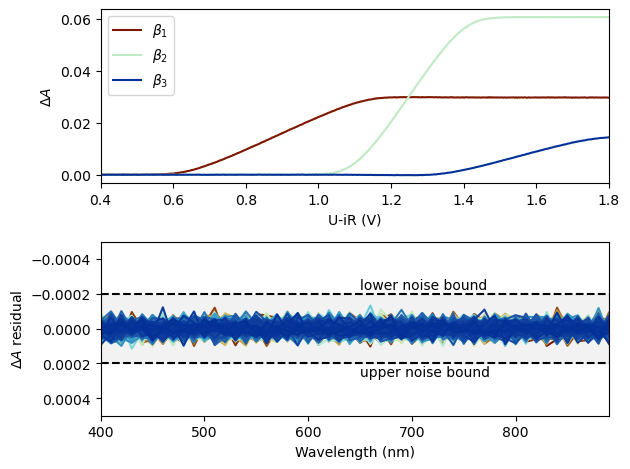

In [8]:
# fit the data in spec using the components in compoents_dict
#  iterate through each collumn in spec and fit the data to the components in compoents_dict
fit_results = {}

bounds_bool=False # use this switch to apply a physicality constraint that the components must increase as the spectral intensity is always increasing
# the strictness of this contrain removes some flexibility so in real data one migth relax it to say that the next component can only be the noise threshold below the previous component
df_spectra=spec_cyle1
df_components=pd.DataFrame(compoents_dict)
# Loop over each column in df_spectra (each spectrum corresponds to a potential)
for i,col in enumerate(df_spectra.columns):
    # Get the spectrum (y) you want to fit
    spectrum = df_spectra[col].values
    
    # Get the component spectra (X)
    components = df_components.values  # The component spectra (X)

    # Get the potential (U) from the column name (assuming it's a float)
    U = float(col)
    
    # if i>0 the lower bound of each component is the fit results of the previous iteration
    if bounds_bool:
        if i>0:
            bounds = (fit_results[df_spectra.columns[i-1]], np.inf)
        else:
            bounds = (0, np.inf)
  

    # Perform the linear combination fit using bounded least squares
    # We are solving y = X * coefficients, with bounds on the coefficients for components A and B

        result = lsq_linear(components, spectrum, bounds=bounds)
    else:
        result = lsq_linear(components, spectrum)
    
    # Store the resulting coefficients in the dictionary
    fit_results[col] = result.x  # 'result.x' contains the optimal coefficients

# Convert the fit results dictionary into a DataFrame for better readability
df_fit_results = pd.DataFrame(fit_results, index=[r'$\beta_1$', r'$\beta_2$',r'$\beta_3$'])

fig3, ax3 = plt.subplots(nrows=2)

df_fit_results.T.plot(colormap=cmc.roma, legend=True, ax=ax3[0])

print( df_components.shape, df_fit_results.shape)



reconstructed=pd.DataFrame(df_components.values@df_fit_results.values, index=df_components.index, columns=df_spectra.columns)

residuals=spec_cyle1-reconstructed

residuals.plot(colormap=cmc.roma,legend=False, ylim=(2E-4,-2E-4),ax=ax3[1])

# add a dashed line at y= 2E-4 above it label 'upper noise bound'
ax3[1].axhline(2E-4, color='black', linestyle='--')
ax3[1].text(650, 2.5E-4, 'upper noise bound', rotation=0, verticalalignment='center')
ax3[1].axhline(-2E-4, color='black', linestyle='--')
ax3[1].text(650, -2.5E-4, 'lower noise bound', rotation=0, verticalalignment='center')

# fill the area between the two dashed lines with a light grey color
ax3[1].fill_between(reversibility_residuals.index, 2E-4, -2E-4, color='grey', alpha=0.1)

# ax3[1] y lime 5E-4 to -5E-4
ax3[1].set_ylim(5E-4,-5E-4)

ax3[1].set_xlim(400,890)

ax3[0].set_xlim(0.4,1.8)

ax3[0].set_xlabel('U-iR (V)')
ax3[0].set_ylabel(r'$\Delta A$')

ax3[1].set_xlabel('Wavelength (nm)')
ax3[1].set_ylabel(r'$ \Delta A$ residual')

# tight layout 
plt.tight_layout()

In [13]:
compoents_dict[0.6].to_csv(Path.cwd().joinpath('Data').joinpath('comp1spectrum.csv'))

In [12]:
compoents_dict.keys()

dict_keys([0.6, 1.25, 1.65])